In [ ]:
#| default_exp gan
from nbdev.showdoc import *
import numpy as np
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torch
import torch_geometric
%load_ext autoreload
%autoreload 2

# 04 Directed Graph Embedding by GAN
> Learning a flow field that, when sampled, matches a class of directed graphs

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from FEARFRED.generator import *
from FEARFRED.discriminator import *
from FEARFRED.graph_builder import *
class FRED_A_GAN(nn.Module):
    def __init__(self,
                 intrinsic_dimension, # intrinsic dimension of data
                 n_nodes, # number of nodes in directed subgraphs
                 n_features, # number of features per node
                ):
        super().__init__()
        self.intrinsic_dimension = intrinsic_dimension
        self.n_nodes = n_nodes
        self.n_features = n_features + 1 # we include an extra vector of 1s when feeding to the discriminator
        # initialize GAN machineru
        self.generator = FlowGenerator(self.intrinsic_dimension,n_features) # generates the actual number of featuers
        self.discriminator = ScatteringDiscriminator(self.n_nodes,self.n_features)
        
    def generate_fake(self):
        # 1. sample from the unit hypercube
        # TODO: Could adjust this to sample from parts of the hypercube
        # to get localized subgraphs
        samples = torch.randn(self.n_nodes,self.intrinsic_dimension)
        # 2. Translate to a sample in the embedding space, and take flows
        points, flows, features = self.generator(samples)
        # 3. construct a directed graph based off of these points and flows, 
        # and create summary node features for it
        A = flashlight_kernel(points,flows,kernel_type='fixed', sigma=0.7)
        # simplify graph with this nonlinearity
        A[A<0.01] = 0
        # TODO: Might have to revise that.
        node_features = torch.ones(self.n_nodes,self.n_features).float()
        node_features[:,1:] = features
        return A, node_features
    
    def train_critic(self, A, features):
        # generate a fake image and run it through the discriminator
        fakeA, fake_features = self.generate_fake()
        # detach gradients when training critic, to prevent unnecessary backprop graph construction
        fakeA = fakeA.detach()
        fake_features = fake_features.detach()
        witness_of_fake = self.discriminator(fakeA,fake_features)
        
        # Test the critic on real data
        node_features = torch.ones(self.n_nodes,self.n_features).float()
        node_features[:,1:] = features
        # Run through discriminator and compute loss
        witness_of_real = self.discriminator(A,node_features)
        # Loss is the difference between the witness function of fake and real
        # The critic wants to maximize this difference
        loss = witness_of_fake - witness_of_real
        return loss
        
    def train_generator(self,A,features):
        # 1. sample from the unit hypercube
        # TODO: Could adjust this to sample from parts of the hypercube
        # to get localized subgraphs
        fakeA, fake_features = self.generate_fake()
        # 4. Run the graph and its features through the discriminator
        witness_of_fake = self.discriminator(fakeA,fake_features)
        # generator wants to minimize the witness function on its data
        loss = - witness_of_fake
        return loss
        

Testing that it runs on fake data

In [ ]:
A = torch.rand(10,10)
features = torch.rand(10,2)
fredtest = FRED_A_GAN(
    intrinsic_dimension = 2,
    n_nodes = 10,
    n_features = 2
)

In [ ]:
l_g = fredtest.train_generator(A,features)

In [ ]:
l_d = fredtest.train_critic(A,features)

# Training

In [ ]:
n_epochs = 500
n_critic = 5 # number of times to train the critic for each training iteration of the generator
weight_clipping_value = 0.01
fred = FRED_A_GAN(
    intrinsic_dimension = 2,
    n_nodes = 128,
    n_features = 1
)
opt_gen = torch.optim.Adam(fred.generator.parameters())
opt_discrim = torch.optim.Adam(fred.discriminator.parameters())

In [ ]:
from FEARFRED.datasets.manifolds import DirectedCircle
from torch.utils.data import DataLoader

In [ ]:
d = DirectedCircle()
dataloader = DataLoader(d, batch_size=1)

  0%|                                                    | 0/500 [00:00<?, ?it/s]

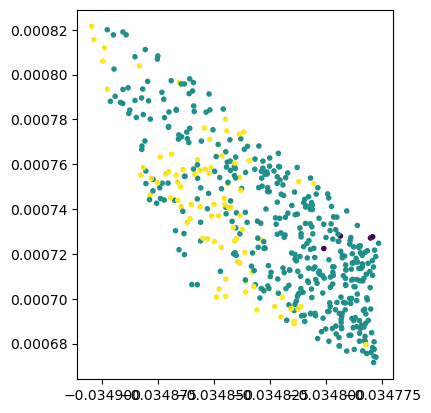

 10%|████▎                                      | 50/500 [01:39<14:57,  1.99s/it]

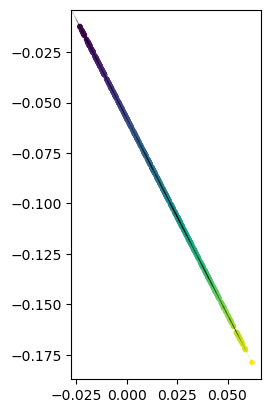

 20%|████████▍                                 | 100/500 [03:19<13:20,  2.00s/it]

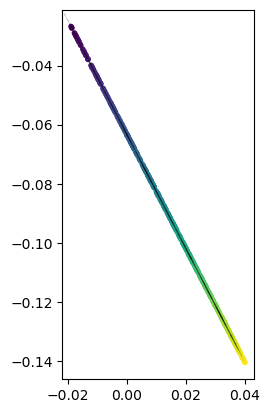

 30%|████████████▌                             | 150/500 [04:58<11:27,  1.96s/it]

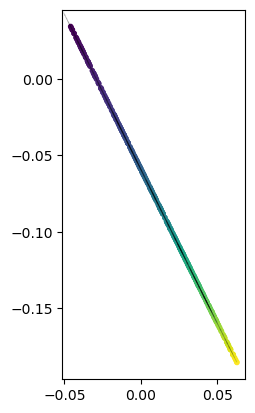

 40%|████████████████▊                         | 200/500 [06:37<09:49,  1.97s/it]

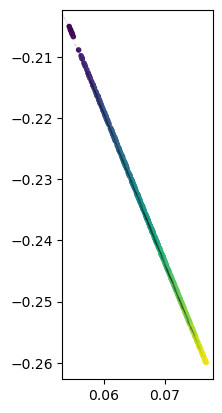

 50%|█████████████████████                     | 250/500 [08:15<08:11,  1.96s/it]

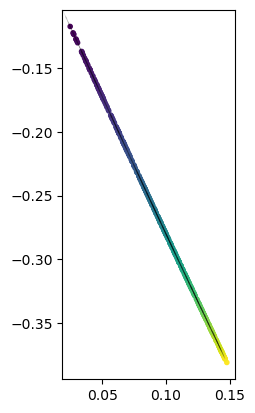

 60%|█████████████████████████▏                | 300/500 [09:54<06:34,  1.97s/it]

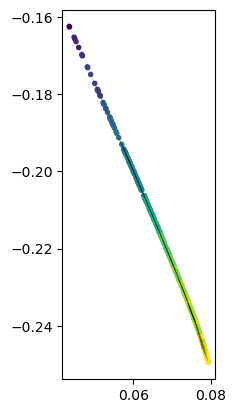

 70%|█████████████████████████████▍            | 350/500 [11:33<04:57,  1.98s/it]

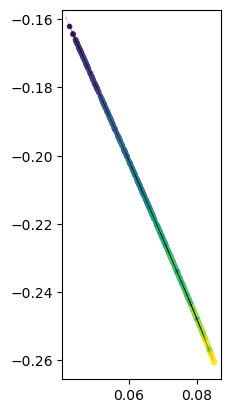

 80%|█████████████████████████████████▌        | 400/500 [13:12<03:16,  1.96s/it]

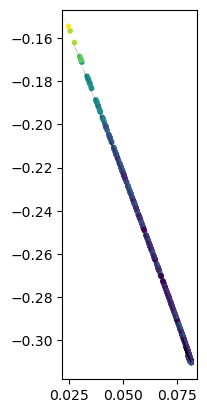

 90%|█████████████████████████████████████▊    | 450/500 [14:51<01:39,  1.98s/it]

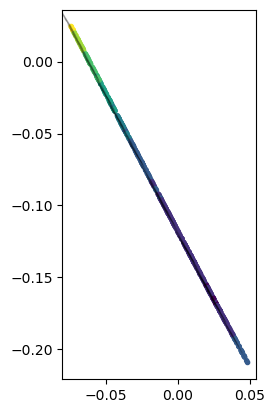

100%|██████████████████████████████████████████| 500/500 [16:29<00:00,  1.98s/it]


In [ ]:
from FEARFRED.plotting import plot_flow_field_2d
for e in trange(n_epochs):
    i = 0
    for A, features in dataloader:
        i += 1
        # shape wrangling: presently each batch has but a single matrix and list of features
        A = A[0].float()
        features = features[0][:,None] # reshape to n_nodes x n_features
        features = features.float()
        
        opt_discrim.zero_grad()
        loss = fred.train_critic(A, features)
        if loss.item() != loss.item():
            print("A nan has been found in d! investigate please")
            raise NotImplementedError
        loss.backward()
        opt_discrim.step()
        # print('discrim loss',loss)
        
        for p in fred.discriminator.parameters():
            p.data.clamp_(-weight_clipping_value, weight_clipping_value)

        if i % n_critic == 0:
            # Train generator
            opt_gen.zero_grad()
            loss = fred.train_generator(A, features)
            # print('gen loss',loss)
            if loss.item() != loss.item():
                print("A nan has been found in g! investigate please")
                raise NotImplementedError
            loss.backward()
            opt_gen.step()
    if e % 50==0:
        plot_flow_field_2d(fred.generator)
        

Here are some visualization functions to gauge progress during training

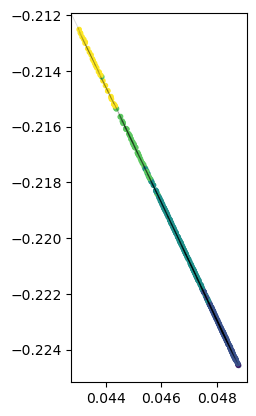

In [ ]:
from FEARFRED.plotting import plot_flow_field_2d
plot_flow_field_2d(fred.generator) 

In [ ]:
fred.generate_fake()

(tensor([[0.0000, 0.4712, 0.0761,  ..., 0.0743, 0.0746, 0.0739],
         [0.0922, 0.0000, 0.0756,  ..., 0.0739, 0.0742, 0.0735],
         [0.5618, 0.5587, 0.0000,  ..., 0.0754, 0.0757, 0.0749],
         ...,
         [0.5492, 0.5459, 0.5567,  ..., 0.0000, 0.3682, 0.0916],
         [0.5514, 0.5481, 0.5590,  ..., 0.1184, 0.0000, 0.0764],
         [0.5460, 0.5427, 0.5535,  ..., 0.4742, 0.5643, 0.0000]],
        grad_fn=<IndexPutBackward0>),
 tensor([[1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1029],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1028],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000, 3.1027],
         [1.0000,

In [ ]:
node_features = torch.ones(len(A),2)
node_features[:,1:] = features

In [ ]:
fred.discriminator(A,node_features)

tensor([[-0.0095]], grad_fn=<AddmmBackward0>)